In [1]:
# !pip install lava-nc
# !pip install networkx==2.8
# !pip install matplotlib
# !pip install cvxpy
# !pip install lava-nc
# !pip install pandas
# !pip install python-louvain

In [2]:
# !pip uninstall networkx -y
# install latest version of networkx
# !pip install networkx==2.8.7

In [3]:
import lava
import cProfile
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
from mod_one_exchange_new import mod_one_exchange_approximation_new
from mod_one_exchange import mod_one_exchange_approximation
import graph_col_dimacs_reader as reader
import goemans_williamson_sdp as gw_sdp
import scipy
import matplotlib
import re
import time
import sys
import community as community_louvain

In [4]:
# print version of networkx
print(nx.__version__)

2.8.7


In [5]:
def density(adj_matrix):
    return np.sum(adj_matrix) / (adj_matrix.shape[0] * (adj_matrix.shape[1]-1))

In [6]:
def graph_to_mat(G, path = 'test_graphs/default2.mat'):
    # get the adjancency matrix of the graph
    adj = nx.adjacency_matrix(G).toarray()
    adj = np.asarray(adj, dtype=np.int32)
    scipy.io.savemat(path, {'M': adj})   # M for matrix, to stay consistent with the .mat files we already have
    return

def mat_to_graph(path):
    mat = scipy.io.loadmat(path)
    G = nx.from_numpy_array(mat['M'])
    return G

In [11]:
from GraphColoringTest import gen_permutation_matrix, get_chr, compute_loss, gen_cyclic_graph
import GraphColoringSoln as GC
from lava.magma.core.run_configs import Loihi1SimCfg
from lava.magma.core.run_conditions import RunSteps
from lava.proc.monitor.process import Monitor


# define a function graph_painter, input would be a adjacency matrix, output should be a 1-d array of colors
def graph_painter(adj,phi_init):
    # adj is a numpy array
    B = adj
    num_nodes = B.shape[0]
    conns = np.sum(B, axis=1)
    Cscale = 0.1
    C = (1.0 - adj)
    connsC = np.sum(C, axis=1)

    # init_range = 0.95*np.pi
    # phi_init = np.random.uniform(-init_range, init_range, size=(num_nodes,))

    cos_phi_init = np.cos(phi_init)
    sin_phi_init = np.sin(phi_init)

    lr = 0.01

    lrc = lr*(num_nodes - conns)/(num_nodes)
    lrr = Cscale*lr*conns/(num_nodes)
    tau = 500
    decay = 1 - 1/tau
    sigma = 0.01
    num_steps = 2000

    nodes = GC.OScillatoryNeuronBasic(shape=(num_nodes,), phi=phi_init, sigma=sigma, decay=decay, lrc=lrc)
    connections = GC.GraphColorUpdateBasic(shape=(num_nodes,), shape_mat=(num_nodes, num_nodes), B=B)
    phi_monitor = Monitor()

    nodes.cos_out.connect(connections.cos_in)
    nodes.sin_out.connect(connections.sin_in)

    connections.B_cos_out.connect(nodes.B_cos_in)
    connections.B_sin_out.connect(nodes.B_sin_in)
    #connections.C_cos_out.connect(nodes.C_cos_in)
    #connections.C_sin_out.connect(nodes.C_sin_in)
    phi_monitor.probe(nodes.phi, num_steps)
    
    nodes.run(condition=RunSteps(num_steps=num_steps), run_cfg=Loihi1SimCfg())
    phi_vals = phi_monitor.get_data()
    nodes.stop()
    # print(list(phi_vals.keys()))
    phi_history = phi_vals[list(phi_vals.keys())[0]]['phi']
    # phi_history = phi_vals['Process_0']['phi']

    last_phi = phi_history[-1,:]
    P, order = gen_permutation_matrix(last_phi)
    # chromatic_number, min_color_blocks = get_chr(P, adj, order)
    # print("order-based chromatic number at simulation end: ", chromatic_number)
    # print("color blocks at simulation end: ", min_color_blocks)
    
    print_fr = 500
    chr_ns = []
    min_chr_n = num_nodes
    min_ind = 0
    min_chr_n_color_blocks = [[i] for i in range(num_nodes)]
    for i in range(phi_history.shape[0]):
        # if i%print_fr == print_fr-1:
        #     print("computing for iter: ", i+1)
        #     print("minimum chromatic number: ", min_chr_n)
        curr_phi = phi_history[i,:]
        P, order = gen_permutation_matrix(curr_phi)
        chr_n, chr_n_color_blocks = get_chr(P, adj, order)  # changes here
        if chr_n<min_chr_n:
            min_chr_n = chr_n
            min_ind = i
            min_chr_n_color_blocks = chr_n_color_blocks
        chr_ns.append(chr_n)
    
    # print("minimum order-based chromatic number during simulation: ", min_chr_n)
    # print("color blocks at minimum chromatic number: ", min_chr_n_color_blocks)

    return min_chr_n_color_blocks, phi_history, curr_phi

def get_color_indice_array(color_blocks, adj):
    color_indice_array = np.zeros(adj.shape[0], dtype=np.int32)
    temp_color_index = 0
    for color_block in color_blocks:
        for node in color_block:
            color_indice_array[node] = temp_color_index
        temp_color_index += 1
    num_colors = temp_color_index
    return color_indice_array, num_colors

def get_color_adj_graph(color_indice_array, adj, num_colors):
    color_adj = np.zeros((num_colors,num_colors), dtype=np.int32)
    for i in range(adj.shape[0]):
        for j in range(adj.shape[0]):
            if adj[i][j] == 1:
                color_adj[color_indice_array[i]][color_indice_array[j]] = 1
    return color_adj



In [8]:
def loss_func(phi_history, adj):
    num_nodes = adj.shape[0]
    loss_list = []
    for i in range (len(phi_history)):
        curr_phi = phi_history[i]
        loss = 0
        for j in range (num_nodes):
            for k in range (j):
                if(adj[j][k] == 1):
                    loss -= 1 - np.cos(curr_phi[j] - curr_phi[k])
        loss_list.append(loss)
    return loss_list

def interchange_algo(adj, color_indice_array, num_colors):
    # This shall implement an approximate interchange algorithm from networkx greedy method for graph coloring
    num_nodes = adj.shape[0]
    interchange_list = []
    visited = np.zeros(num_nodes)
    for i in range(num_nodes):
        for j in range(i, num_nodes):
            if(visited[i] == 1 or visited[j] == 1 or i==j):
                continue
            if(color_indice_array[i] != color_indice_array[j]):
                flag = 1
                for k in range(num_nodes):
                    if(k!=j and color_indice_array[k] == color_indice_array[j] and adj[i][k] == 1):
                        flag = 0
                        break
                if flag == 1:
                    for k in range(num_nodes):
                        if(k!=i and color_indice_array[k] == color_indice_array[i] and adj[j][k] == 1):
                            flag = 0
                            break
                if flag == 1:
                    interchange_list.append((i,j))
                    visited[i] = 1
                    visited[j] = 1
                    break       
    return interchange_list

In [9]:
def graph_painter_multi_level(adj, phi_init, level):
    num_nodes = adj.shape[0]
    color_blocks, phi_history, curr_phi = graph_painter(adj, phi_init)
    color_indice_array, num_colors = get_color_indice_array(color_blocks, adj)
    color_adj1 = get_color_adj_graph(color_indice_array, adj, num_colors)
    if(density(color_adj1) == 1):
        print("Level: ", level)
        return color_blocks, phi_history, curr_phi
    else:
        phi_init_adj = 0.7*np.random.uniform(-np.pi, np.pi, size=(num_colors,))
        color_blocks_adj, phi_history_adj, curr_phi_adj = graph_painter_multi_level(color_adj1, phi_init_adj, level+1)
        color_indice_array_adj, num_colors_adj = get_color_indice_array(color_blocks_adj, color_adj1)
        new_color_indice_array = []
        for i in range(len(color_indice_array)):
            new_color_indice_array.append(color_indice_array_adj[color_indice_array[i]])
        new_color_blocks = []
        for i in range(num_colors_adj):
            new_color_blocks.append([])
        for i in range(num_nodes):
            new_color_blocks[new_color_indice_array[i]].append(i)
        return new_color_blocks, phi_history, curr_phi


In [10]:
# huck, myciel3, myciel4, myciel5, myciel6

/tmp/ipykernel_70659/4243994914.py:4: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  adj = nx.adjacency_matrix(G).toarray()


Level:  7
Initial Loss:  -11106.564584718199
Final Loss:  -15293.064761058906
num_colors:  51
Density of the original graph:  0.09986372745490982
Density of the colored graph:  1.0


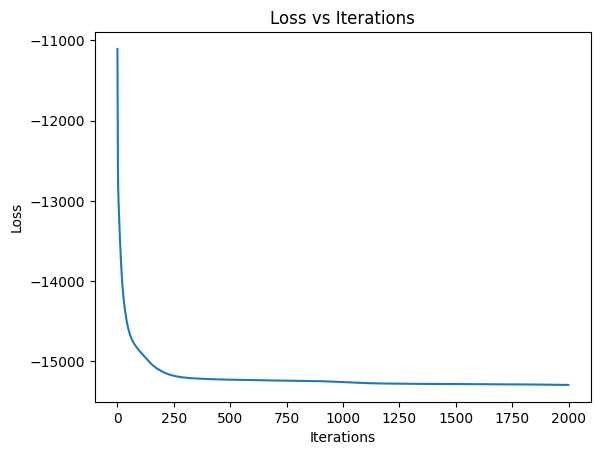

Number of interchanges:  247
Level:  12
Loss:  -15311.666130855065
num_colors:  49
Density of the original graph:  0.09986372745490982
Density of the colored graph:  1.0


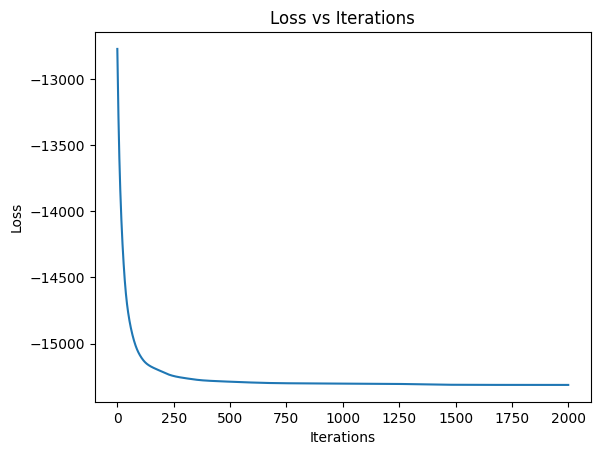

In [35]:
path = 'test_graphs/dsjc500.1'
# path = 'test_graphs/queen55.mat'
G = mat_to_graph(path)
adj = nx.adjacency_matrix(G).toarray()
num_nodes = adj.shape[0]
init_range = 0.7*np.pi
phi_init = np.random.uniform(-init_range, init_range, size=(num_nodes,))
color_blocks, phi_history, curr_phi = graph_painter_multi_level(adj, phi_init,0)
loss_list = loss_func(phi_history, adj)
print("Initial Loss: ", loss_list[0])
print("Final Loss: ", loss_list[-1])
color_indice_array, num_colors = get_color_indice_array(color_blocks, adj)
color_adj1 = get_color_adj_graph(color_indice_array, adj, num_colors)
print("num_colors: ", num_colors)
print("Density of the original graph: ", density(adj))
print("Density of the colored graph: ", density(color_adj1))
# Plotting the loss
plt.plot(loss_list)
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.title('Loss vs Iterations')
plt.show()

interchange_list = interchange_algo(adj, color_indice_array,num_colors)
print("Number of interchanges: ", len(interchange_list))
for swap_pairs in interchange_list:
    curr_phi[swap_pairs[0]], curr_phi[swap_pairs[1]] = curr_phi[swap_pairs[1]], curr_phi[swap_pairs[0]]
color_blocks, phi_history, curr_phi = graph_painter_multi_level(adj,curr_phi,0)
loss_list = loss_func(phi_history, adj)
print("Loss: ", loss_list[-1])
color_indice_array, num_colors = get_color_indice_array(color_blocks, adj)
color_adj1 = get_color_adj_graph(color_indice_array,adj, num_colors)
print("num_colors: ", num_colors)
print("Density of the original graph: ", density(adj))
print("Density of the colored graph: ", density(color_adj1))
# Plotting the loss
plt.plot(loss_list)
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.title('Loss vs Iterations')
plt.show()


In [36]:
phi_init = np.random.uniform(-init_range, init_range, size=(num_colors,))
color_blocks, phi_history, curr_phi = graph_painter(color_adj1, phi_init)
color_indice_array, num_colors = get_color_indice_array(color_blocks, color_adj1)
color_adj2 = get_color_adj_graph(color_indice_array, color_adj1, num_colors)
print("num_colors: ", num_colors)
print("Density of the original graph: ", density(color_adj1))
print("Density of the colored graph: ", density(color_adj2))
# Print the color adj fully in a readable format
print("Color adjacency matrix: ")
for i in range(color_adj2.shape[0]):
    print(color_adj2[i])

num_colors:  49
Density of the original graph:  1.0
Density of the colored graph:  1.0
Color adjacency matrix: 
[0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1]
[1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1]
[1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1]
[1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1]
[1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1]
[1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1]
[1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1]
[1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1]
[1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 

In [368]:
phases_ordered

array([3, 1, 4, 2, 0])

In [369]:
np.cos(phases_scaled[phases_ordered]*np.pi)

array([ 1.        ,  0.3090151 , -0.80901722, -0.80901641,  0.30901853])

In [371]:
print(loss(phi_history)[0])
print(loss([phi_end])[0])

-7.5
-9.045084971873205


In [267]:
# # read dsjc500.5.mat
# G = mat_to_graph('test_graphs/queen55.mat')
# adj = nx.adjacency_matrix(G).toarray()
# adj = np.asarray(adj, dtype=np.int32)
adj = gen_cyclic_graph(20)
G = nx.from_numpy_array(adj)
color_blocks, phi_history, phi_end = graph_painter(adj)


Num Colors:  3


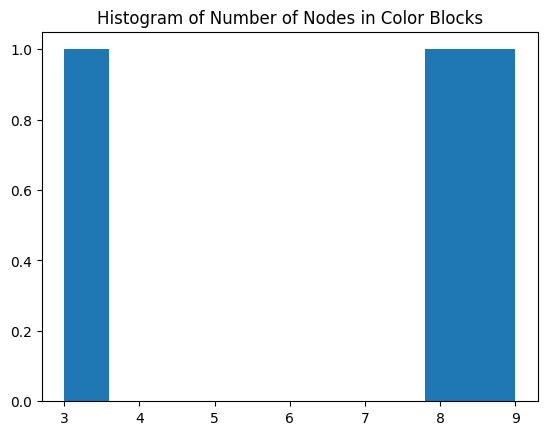

In [268]:
num_colors = len(color_blocks)
print("Num Colors: ", num_colors)
# Plot the histogram of number of colors
color_hist = []
for color_block in color_blocks:
    color_hist.append(len(color_block))
plt.hist(color_hist)
plt.title("Histogram of Number of Nodes in Color Blocks")
plt.show()

In [269]:
print(color_hist)

[9, 8, 3]


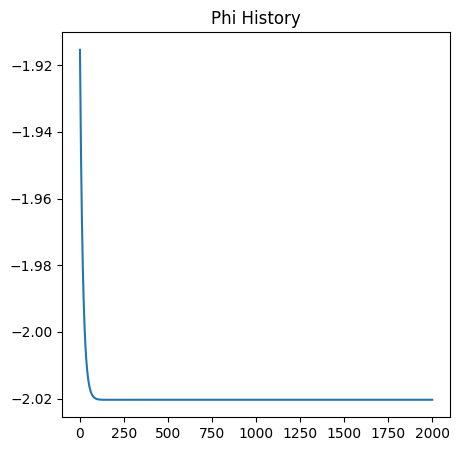

In [187]:
plt.figure(figsize=(5, 5))
plt.plot(phi_history[:,20])
plt.title("Phi History")
# plt.legend([i for i in range(phi_history.shape[1])])
plt.show()

In [123]:
num_colors = 3
# color the graph
iter = 1
while num_colors != 4:
    color_blocks, phi_history = graph_painter(adj)
    num_colors = len(color_blocks)
    print("Iteration: ", iter, " Num Colors: ", num_colors)
    iter += 1


# print("color blocks: ", color_blocks)
# print("Num Colors: ", len(color_blocks))
color_indice_array, num_colors = get_color_indice_array(color_blocks, adj)
# Plot with colors and plot the phi_history in the same plot in same row, give more space to 2nd plot
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
nx.draw(G, with_labels=True, node_color=color_indice_array, cmap=plt.cm.rainbow, node_size=500)
plt.title("Colored Graph")
plt.subplot(1, 2, 2)
plt.plot(phi_history)
plt.title("Phi History")
plt.legend([0, 1, 2, 3])
plt.show()


ValueError: too many values to unpack (expected 2)

In [14]:
# read queen7_7 graph
G = mat_to_graph('test_graphs/dsjc250.5.mat')
adj = nx.adjacency_matrix(G).toarray()



/tmp/ipykernel_17599/2834370043.py:3: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  adj = nx.adjacency_matrix(G).toarray()


community:  1 size:  48
community:  2 size:  46
community:  3 size:  51
community:  4 size:  52
community:  5 size:  53


/tmp/ipykernel_17599/3019626940.py:25: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  adj_temp = nx.adjacency_matrix(temp_subgraph).toarray()


In [ ]:
adj_color2, call_level2 = graph_coloring_louvain_single_level(adj_color, 1.0, call_level+1)
print(adj_color2.shape)
print(density(adj_color2))

community:  1 size:  38
community:  2 size:  39
community:  3 size:  34


/tmp/ipykernel_17599/3019626940.py:25: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  adj_temp = nx.adjacency_matrix(temp_subgraph).toarray()


In [30]:
adj_color3, call_level3 = graph_coloring_louvain_single_level(adj_color2, 1.002, call_level2+1)
print(adj_color3.shape)
print(density(adj_color3))

community:  1 size:  41
community:  2 size:  46


/tmp/ipykernel_17599/3019626940.py:25: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  adj_temp = nx.adjacency_matrix(temp_subgraph).toarray()


(82, 82)
0.991869918699187


In [35]:
from networkx.algorithms.community import greedy_modularity_communities

def graph_coloring_greedy_single_level(adj,resolution,call_level):
    adj = np.asarray(adj, dtype=np.int32)
    G = nx.from_numpy_array(adj)
    partition = greedy_modularity_communities(G, resolution=resolution)
    # Partition consists of list of frozen sets
    partition = {node: i for i, comm in enumerate(partition) for node in comm}
    pos = {}
    communities = {}
    colors = {}
    num_colors_array = []
    node_wise_colors = {}
    map_indices_array = []
    values = [partition.get(node) for node in G.nodes()]
    colors_offset = 0

    for node, comm in partition.items():
        communities.setdefault(comm, []).append(node)

    # print the sizes of the communities
    for i, (comm, nodes) in enumerate(communities.items()):
        print("community: ", i+1, "size: ", len(nodes))

    for i, (comm, nodes) in enumerate(communities.items()):
        map_indice_temp = {}
        map_indices_array.append(map_indice_temp)
        temp_subgraph = G.subgraph(nodes)
        adj_temp = nx.adjacency_matrix(temp_subgraph).toarray()
        adj_temp = np.asarray(adj_temp, dtype=np.int32)

        for i, sub_node in enumerate(temp_subgraph.nodes()):
            map_indice_temp[sub_node] = i

        density = np.sum(adj_temp) / (adj_temp.shape[0] * (adj_temp.shape[0] - 1))
        color_blocks = graph_painter(adj_temp)
        color_indice_array, num_colors = get_color_indice_array(color_blocks, adj_temp)
        colors[i] = color_indice_array
        
        for node in nodes:
            node_wise_colors[node] = color_indice_array[map_indice_temp[node]] + colors_offset
        colors_offset += num_colors
        num_colors_array.append(num_colors)
  
    total_colors = sum(num_colors_array)
    adj_color = np.zeros((total_colors, total_colors), dtype=np.int32)
    for i in range(adj.shape[0]):
        for j in range(adj.shape[1]):
            if(adj[i][j] == 1):
                adj_color[node_wise_colors[i]][node_wise_colors[j]] = 1
    
    return adj_color, call_level

In [39]:
G = mat_to_graph('test_graphs/dsjc250.5.mat')
adj = nx.adjacency_matrix(G).toarray()
adj = np.asarray(adj, dtype=np.int32)
adj_color, call_level = graph_coloring_greedy_single_level(adj, 10, 0)
print(adj_color.shape)
print(density(adj_color))

/tmp/ipykernel_17599/3900167169.py:2: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  adj = nx.adjacency_matrix(G).toarray()


community:  1 size:  117
community:  2 size:  115
community:  3 size:  18


/tmp/ipykernel_17599/1621547714.py:29: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  adj_temp = nx.adjacency_matrix(temp_subgraph).toarray()


KeyboardInterrupt: 

(123, 123)
0.868452618952419


In [13]:
import networkx as nx
import numpy as np
from networkx.algorithms.coloring.greedy_coloring import interchange

# Example custom graph coloring function (replace this with your actual function)
def custom_graph_coloring(adj_matrix):
    """Your custom coloring algorithm that returns color blocks."""
    # Dummy implementation: assign each node a separate color
    return [[i] for i in range(len(adj_matrix))]

# Convert color blocks to a color mapping
def color_blocks_to_mapping(color_blocks):
    """Convert color blocks (list of lists) into a node-color mapping."""
    node_color_mapping = {}
    for color, nodes in enumerate(color_blocks):
        for node in nodes:
            node_color_mapping[node] = color
    return node_color_mapping

# Example graph
G = mat_to_graph('test_graphs/dsjc500.5.mat')
adj_matrix = nx.adjacency_matrix(G).toarray()

# Step 1: Use your custom coloring algorithm
color_blocks = custom_graph_coloring(adj_matrix)

# Step 2: Convert color blocks to a mapping
node_color_mapping = color_blocks_to_mapping(color_blocks)

# Step 3: Apply interchange algorithm to refine the coloring
optimized_coloring = interchange(G, node_color_mapping)

# Step 4: Print the final coloring
print("Initial Coloring:", node_color_mapping)
print("Optimized Coloring:", optimized_coloring)


ImportError: cannot import name 'interchange' from 'networkx.algorithms.coloring.greedy_coloring' (/home/kunal/Desktop/Sem_9/DDP/Maxcut/.venv/lib/python3.10/site-packages/networkx/algorithms/coloring/greedy_coloring.py)

In [7]:
import cProfile, pstats, io
from pstats import SortKey
pr = cProfile.Profile()
pr.enable()


thresholds = [20,30,50,100]
# This attempt uses simple merging without any optimization
def graph_coloring1(adj, threshold=1000000):
    if adj.shape[0] <= threshold:
        return graph_painter(adj)
    else:
        adj1, adj0, cut, map_index1, map_index0, reverse_map = moe_maxcut(adj)
        colors1 = graph_coloring1(adj1)
        colors0 = graph_coloring1(adj0)
        colors_merged = []
        for color_block in colors1:
            temp_list = []
            for node in color_block:
                temp_list.append(map_index1[node])
            colors_merged.append(temp_list)
        
        for color_block in colors0:
            temp_list = []
            for node in color_block:
                temp_list.append(map_index0[node])
            colors_merged.append(temp_list)

    return colors_merged        

In [8]:
def graph_coloring_multi_levels(adj, thresholds):
    num_nodes = adj.shape[0]
    num_edges = np.sum(adj)/2
    density = 2*num_edges/(num_nodes*(num_nodes-1))
    print("Density: ", density)
    if density == 1:
        print("The graph is a complete graph with number of nodes: ", num_nodes)
        return
        

    for threshold in thresholds:
        print("Threshold: ", threshold)
        colors = graph_coloring1(adj, threshold)
        cnt = 0
        for color in colors:
            cnt += len(color)
        print("Number of nodes colored: ", cnt)
        print("Number of colors used: ", len(colors))

        color_array, num_colors = get_color_indice_array(colors, adj)
        # print(color_array)

        # Optimization 1: Merge the color blocks with the same color
        adj_opt1 = np.zeros((num_colors, num_colors))
        for i in range (adj.shape[0]):
            for j in range (adj.shape[0]):
                if adj[i, j] == 1:
                    adj_opt1[color_array[i], color_array[j]] = 1
                    adj_opt1[color_array[j], color_array[i]] = 1

        
        graph_coloring_multi_levels(adj_opt1, thresholds)

        

In [19]:
thresholds = [40]
col_graph_names = ['dsjc125.1','dsjc125.5','dsjc250.5','dsjc500.1','dsjc500.5','dsjc500.9','dsjc1000.1','dsjc1000.5','dsjc1000.9','dsjr500.1c','dsjr500.5','flat300_28_0','flat1000_50_0','flat1000_60_0','flat1000_76_0','latin_square','le450_25c','le450_25d','myciel6','myciel7','queen6_6','r250.5','r1000.1c','r1000.5']
    # graph = 'dsjc500.1'
col_graph_names2 = ['dsjc1000.1','dsjc1000.5','dsjc1000.9']
for graph in col_graph_names2:
    G = mat_to_graph('test_graphs/' + graph + '.mat')
    adj = nx.adjacency_matrix(G).toarray()
    adj = np.asarray(adj, dtype=np.int32)
    num_nodes = adj.shape[0]
    num_edges = np.sum(adj)/2
    density = 2*num_edges/(num_nodes*(num_nodes-1))
    print("Graph: ", graph)
    print("Number of nodes: ", num_nodes)   
    print("Number of edges: ", num_edges)
    print("Density: ", density)
    graph_coloring_multi_levels(adj, thresholds)

Graph:  dsjc1000.1
Number of nodes:  1000
Number of edges:  49629.0
Density:  0.09935735735735736
Threshold:  40
minimum order-based chromatic number during simulation:  100
minimum order-based chromatic number during simulation:  103
Number of nodes colored:  1000
Number of colors used:  224
Threshold:  40
minimum order-based chromatic number during simulation:  79
minimum order-based chromatic number during simulation:  64
Number of nodes colored:  224
Number of colors used:  164
Threshold:  40
minimum order-based chromatic number during simulation:  67
minimum order-based chromatic number during simulation:  56
Number of nodes colored:  164
Number of colors used:  135
Threshold:  40
minimum order-based chromatic number during simulation:  65
minimum order-based chromatic number during simulation:  46
Number of nodes colored:  135
Number of colors used:  121
Threshold:  40
minimum order-based chromatic number during simulation:  60
minimum order-based chromatic number during simulati

KeyboardInterrupt: 

In [ ]:
# IGNORE THE CODE AHEAD

In [8]:
def check_validity(G_sub1,G_sub2,G,color_blocks1,color_blocks2,cut,part1,part2):
    colors1 = np.zeros(G_sub1.number_of_nodes())
    colors2 = np.zeros(G_sub2.number_of_nodes())
    color_index = 0
    for i,block in enumerate(color_blocks1):
        for node in block:
            colors1[node] = color_index
        color_index += 1
    for i,block in enumerate(color_blocks2):
        for node in block:
            colors2[node] = color_index
        color_index += 1

    # check if the coloring is valid
    valid_coloring1 = True
    valid_coloring2 = True
    for edges in G_sub1.edges:
        if colors1[edges[0]] == colors1[edges[1]]:
            valid_coloring1 = False
            print("Invalid coloring for subgraph 1")
            print(edges)
    for edges in G_sub2.edges:
        if colors2[edges[0]] == colors2[edges[1]]:
            valid_coloring2 = False
            print("Invalid coloring for subgraph 2")
            print(edges)

    if(valid_coloring1):
        print("Valid coloring for subgraph 1")
    if(valid_coloring2):
        print("Valid coloring for subgraph 2")

    # combine the two colorings
    # Using two pointers approach
    i = 0
    j = 0
    k = 0

    merged_colors = np.zeros(G.number_of_nodes())
    
    while i < G_sub1.number_of_nodes() and j < G_sub2.number_of_nodes():
        if cut[k] == 0:
            merged_colors[part1[i]] = colors1[i]
            i += 1
        else:
            merged_colors[part2[j]] = colors2[j]
            j += 1
        k += 1
    while i < G_sub1.number_of_nodes():
        merged_colors[part1[i]] = colors1[i]
        i += 1
        k += 1

    while j < G_sub2.number_of_nodes():
        merged_colors[part2[j]] = colors2[j]
        j += 1
        k += 1

    # check if the coloring is valid
    valid_coloring = True
    for edges in G.edges:
        if merged_colors[edges[0]] == merged_colors[edges[1]]:
            valid_coloring = False
            print("Invalid coloring for full Graph")
            print(edges)
    if valid_coloring:
        print("Valid coloring for full Graph")
    return merged_colors


def check_reducibility(num_colors, merged_colors, G):
    color_adj = np.zeros((num_colors, num_colors))
    for edges in G.edges():
        color_adj[int(merged_colors[edges[0]])][int(merged_colors[edges[1]])] = 1
        color_adj[int(merged_colors[edges[1]])][int(merged_colors[edges[0]])] = 1
    
    temp_check = np.ones((num_colors,num_colors))-np.eye(num_colors)
    flag = np.array_equal(color_adj,temp_check)
    if flag:
        print("Not reducible")
    else:
        print("Reducible")
    
    print(color_adj)
    return flag, color_adj


def min_chromatic_number(G):
    # Use networkx's greedy_color algorithm to assign colors # Might not be complete
    color_assignment = nx.coloring.greedy_color(G, strategy="largest_first")
    
    # The chromatic number is the maximum color index used + 1
    chromatic_number = max(color_assignment.values()) + 1
    
    # Returning chromatic number and color assignment for nodes
    return chromatic_number, color_assignment
